In [1]:
import yfinance as yf 
import pandas as pd 
from datetime import datetime, timedelta 
import numpy as np 
from scipy.optimize import minimize 

In [7]:
# Define the assets we'll analyze
tickers = ['TSLA', 'BND', 'SPY']

# Define the time period
end_date = "2025-01-31"
start_date = "2015-01-01"


# Fetch the data
#data = yf.download(tickers, start=start_date, end=end_date)
#print("\nData shape:", data.shape)

In [9]:
##Download the close prices for each ticker
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
print(adj_close_df)

                  TSLA        BND         SPY
Date                                         
2015-01-02   14.620667  62.573151  172.592880
2015-01-05   14.006000  62.754803  169.475937
2015-01-06   14.085333  62.936539  167.879608
2015-01-07   14.063333  62.974384  169.971588
2015-01-08   14.041333  62.875938  172.987778
...                ...        ...         ...
2025-01-24  406.579987  71.805977  607.969971
2025-01-27  397.149994  72.184738  599.369995
2025-01-28  398.089996  72.144867  604.520020
2025-01-29  389.100006  72.104996  601.809998
2025-01-30  400.279999  72.204674  605.039978

[2535 rows x 3 columns]


In [12]:
##calculate the lognormal returns for each ticker
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [13]:
log_returns = log_returns.dropna()

In [14]:
##calculate the covariance matrix using annualized log returns 
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          TSLA       BND       SPY
TSLA  0.324849  0.001871  0.047626
BND   0.001871  0.002970  0.001068
SPY   0.047626  0.001068  0.031165


In [15]:
##calculate optimal portfolio weights 
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [16]:
##calculate the expected return
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [17]:
##calculate the sharpe ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [19]:
##to minimize negative sharpe ratio
risk_free_rate = .02

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

print(initial_weights)

[0.33333333 0.33333333 0.33333333]


In [ ]:
##optimize the weights to maximize sharpe ratio
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [20]:
##Analyze the optimal portfolio
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
TSLA: 0.2026
BND: 0.3974
SPY: 0.4000
Expected Annual Return: 0.1222
Expected Volatility: 0.1648
Sharpe Ratio: 0.6205


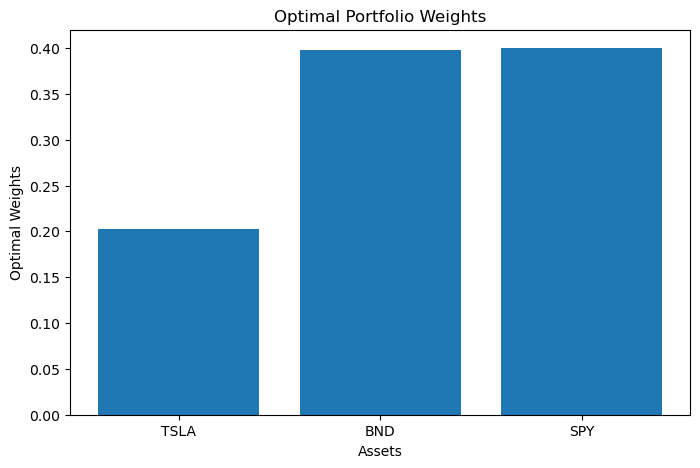

In [23]:
##Display the Final Portfolio in a Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()